In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

import pymc3 as pm
import theano.tensor as T
import theano

from scipy.stats import mode, chisquare

from sklearn.metrics import confusion_matrix, accuracy_score

import lasagne

In [2]:
import sys, os

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

Loading data...


In [3]:
# Building a theano.shared variable with a subset of the data to make construction of the model faster.
# We will later switch that out, this is just a placeholder to get the dimensionality right.
input_var = theano.shared(X_train[:500, ...].astype(np.float64))
target_var = theano.shared(y_train[:500, ...].astype(np.float64))

In [4]:
def build_ann(init):
    
    with pm.Model() as neural_network:
    
        l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                     input_var=input_var)

        # Add a fully-connected layer of 800 units, using the linear rectifier, and
        # initializing weights with Glorot's scheme (which is the default anyway):
        n_hid1 = 800
        l_hid1 = lasagne.layers.DenseLayer(
            l_in, num_units=n_hid1,
            nonlinearity=lasagne.nonlinearities.tanh,
            b=init,
            W=init
        )

        n_hid2 = 800
        # Another 800-unit layer:
        l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units=n_hid2,
            nonlinearity=lasagne.nonlinearities.tanh,
            b=init,
            W=init
        )

        # Finally, we'll add the fully-connected output layer, of 10 softmax units:
        l_out = lasagne.layers.DenseLayer(
            l_hid2, num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax,
            b=init,
            W=init
        )
    
        prediction = lasagne.layers.get_output(l_out)
    
        # 10 discrete output classes -> pymc3 categorical distribution
        out = pm.Categorical('out', prediction, observed=target_var)
    
    return neural_network

In [5]:
class GaussWeights(object):
    def __init__(self):
        self.count = 0
    def __call__(self, shape):
        self.count += 1
        return pm.Normal('w%d' % self.count, mu=0, sd=.1, 
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)

In [6]:
input_var  = theano.shared(X_train[:5000, ...].astype(np.float64))
target_var = theano.shared(y_train[:5000, ...].astype(np.float64))

In [7]:
input_var_mb  = pm.Minibatch(X_train, batch_size=32, dtype=np.float64)
target_var_mb = pm.Minibatch(y_train, batch_size=32, dtype=np.float64)

/u01/anaconda3/lib/python3.6/site-packages/pymc3/data.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/u01/anaconda3/lib/python3.6/site-packages/pymc3/data.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [8]:
neural_network = build_ann(GaussWeights())

/u01/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/u01/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [9]:
%%time
with neural_network:
     inference=pm.ADVI()
     mean_field = pm.fit(n=55000, method=inference, score=True, more_replacements={input_var: input_var_mb, target_var:target_var_mb})

  0%|          | 0/55000 [00:00<?, ?it/s]/u01/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 10,815: 100%|██████████| 55000/55000 [4:30:01<00:00,  3.43it/s]      
Finished [100%]: Average Loss = 10,814


CPU times: user 1d 1h 56min 47s, sys: 2h 12min 44s, total: 1d 4h 9min 31s
Wall time: 4h 30min 11s


Text(0.5, 0, 'iteration')

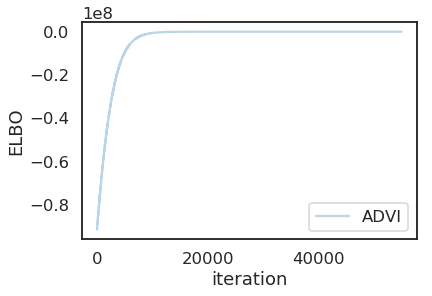

In [10]:
plt.plot(-inference.hist, label='ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration')

In [11]:
%%time
trace = mean_field.sample(500)

CPU times: user 53.6 s, sys: 12.6 s, total: 1min 6s
Wall time: 53.7 s


In [12]:
with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples=5000)

100%|██████████| 5000/5000 [44:12<00:00,  1.62it/s]


In [13]:
ppc['out'].shape

(5000, 5000)

In [14]:
input_var.set_value(X_test[:5000, ...].astype(np.float64))
target_var.set_value(y_test[:5000, ...].astype(np.float64)) 

In [31]:
%%time
with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples=15000)

100%|██████████| 15000/15000 [2:11:40<00:00,  1.95it/s]  

CPU times: user 15h 6min 8s, sys: 59min 26s, total: 16h 5min 35s
Wall time: 2h 11min 40s


In [32]:
ppc['out'].shape

(15000, 5000)

In [33]:
y_pred = mode(ppc['out'], axis=0).mode[0, :]

In [34]:
y_pred[:50]

array([1, 3, 3, 8, 9, 0, 4, 7, 9, 1, 1, 9, 8, 4, 1, 8, 9, 9, 3, 2, 4, 2,
       5, 8, 8, 1, 7, 5, 8, 5, 3, 4, 4, 8, 4, 2, 9, 5, 3, 3, 8, 0, 7, 3,
       4, 8, 5, 9, 5, 4])

In [35]:
y_test[:50, ...]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4], dtype=uint8)

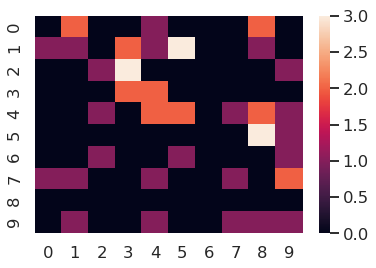

In [36]:
sns.heatmap(confusion_matrix(y_test[:50, ...], y_pred[:50]))

In [37]:
print('Accuracy on test data = {}%'.format(accuracy_score(y_test[:5000], y_pred[:5000]) * 100))

Accuracy on test data = 11.76%
